### Cab-Driver Agent

In [135]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import math
from collections import deque
import collections
import pickle
import os
import time


# for building DQN model 
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix.shape

(5, 5, 24, 7)

In [5]:
Time_matrix.max()

11.0

<font color='green'>
- Maximum time to travel between two locations is 11 hours <br>
- Next state can change by max of 1 day <br>
 
</font>

#### Tracking the state-action pairs for checking convergence


<font color='green'>
    <b>NOTE: </b> <br>
- Following state and action considered for checking convergence: STATE - (1,0,0), ACTION - (1, 3) <br>
- State - location at time 0 and day 0, action is a ride from location 1 to location 3 <br>
- Tracking details are initialized in the Agent class <br>
 
</font>

### TODO  : Picking the architecture

#### Architecture 1: input - state, output - q-value for each possible (state, action)

Pros:
- Model has to be run once for each state  

Cons:
    

#### Architecture 2: input - (state, action), output - q-value for the given (state, action)

#### Conclusion

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN 
        self.discount_factor = 0.99
        self.learning_rate = 0.001       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.00000001
        self.epsilon = 1
    
        self.explore_count = 0
        self.exploit_count = 0
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # Track the state [1,0,0] and action (1,3) at index 7 in the action space.
        self.track_state = np.array(env.state_encod_arch1([1,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()
        
        
        
        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # input layer
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        # hidden layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform')) 
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform')) 
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

     

    def get_action(self, state, episode_count):
    # Write your code here:
    # get action from model using epsilon-greedy policy     
        
        if np.random.rand() <= self.epsilon:
            # exploration: choose a random action from all possible actions 
            self.explore_count += 1
            return random.randrange(self.action_size)

        else:
            # exploitation: choose the action that returns the maximum q-value  
            
            # reshape so that the first index corresponds to the batch size 
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36) 
            q_value = self.model.predict(state) 
            self.exploit_count += 1
            return np.argmax(q_value)
         
 
   
    # Return the summary details for the episode
    def get_summary_details(self):
        return self.explore_count, self.exploit_count
        
        
    # Reset the variables before the start of an episode
    def reset_episode_counts(self):
        self.explore_count = 0
        self.exploit_count = 0

    # save sample <s,a,r,s',done> to the replay memory after every action
    def append_sample(self, state, action_idx, reward, next_state, done):
        self.memory.append((state, action_idx, reward, next_state, done))
         
    

    # Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """

        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            # Initialise the Q(s,a) with zero
            update_input = np.zeros((self.batch_size, self.state_size))
            # Initialise the Q(s',a)
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action_idx, reward, next_state, is_done = minibatch[i]
                # Add state s to the Q(s,a), Q(s',a) from memory
                update_input[i] = env.state_encod_arch1(state)     
                # Add action from memory
                actions.append(action_idx)
                # Add reward from the memory
                rewards.append(reward)
                # Add next state s' to Q(s',a) from the memory
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(is_done)

            # Find the Q(s,a) and Q(s',a) using state as input to the neural network 
        
            # Predict the target q-values from state s
            target = self.model.predict(update_input)

            # Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            # Update the target values - set the target as (r + maxQ(s',a))
            for i in range(self.batch_size):
                # Q Learning: get maximum Q value at s' from target model
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # Train the model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
     

    def save_tracking_states(self):
        # Use the model to predict the q_value for the state tracked
        q_value = self.model.predict(self.track_state)
        
        # Update the q-value for the state tracked
        self.states_tracked.append(q_value[0][7])
        
    def save_model_weights(self, name):
        self.model.save_weights(name)

    def save(self, name):
        self.model.save(name)

### DQN block

In [9]:
Episodes = 5000

env = CabDriver()

m = 5
t = 24
d = 7
# get size of state and action from environment
state_size = m+t+d
action_size = len(env.action_space)

print(f'State size: {state_size}, Action size: {action_size}')

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size) 

# to store rewards in each episode
rewards_per_episode, episodes = [], []

# make dir to store model weights
if not os.path.exists("saved_model_weights"):
    os.mkdir("saved_model_weights")
 
# make dir to store plots
if not os.path.exists("saved_plots"):
    os.mkdir("saved_plots")

summary_df = pd.DataFrame(columns=['EPISODE','REWARD','MEMORY_LENGTH','EPSILON','EXPLORE_CNT', 'EXPLOIT_CNT', 'EPISODE_TIME'])
 
def update_summary_details(episode,reward, memory_len, epsilon, explore_count, exploit_count,episode_time): 
    return summary_df.append({'EPISODE' : episode,
                       'REWARD' : reward,
                       'MEMORY_LENGTH' : memory_len,
                       'EPSILON' : epsilon,
                       'EXPLORE_CNT' : explore_count,
                       'EXPLOIT_CNT' : exploit_count,
                       'EPISODE_TIME': episode_time
                      }, ignore_index=True) 

State size: 36, Action size: 21



PSEUDOCODE - provided in the starter code

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [10]:
start_time = time.time()

for episode in range(Episodes):
    episode_start_time = time.time()
    done = False
    score = 0

    # reset at the start of each episode
    state = env.reset()

    while not done:

        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_idx = agent.get_action(state,episode)
        action = env.action_space[action_idx]
        # 2. Evaluate your reward and next state
        next_state, reward, done = env.step(state, action, Time_matrix)
            
        #next_state, reward, done, info = env.step(action)

        # 3. Append the experience to the memory
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action_idx, reward, next_state, done)

        # 4. Train the model by calling function agent.train_model
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state



    # Decay in ε after we each episode from the environment  
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay 

    # 5. Keep a track of rewards, Q-values, loss
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # Save summary after every episode
    explore_count, exploit_count = agent.get_summary_details()
    episode_time = time.time() - episode_start_time
    summary_df = update_summary_details(episode,score, len(agent.memory),round(agent.epsilon,5),explore_count, exploit_count,round(episode_time,3))
    agent.reset_episode_counts()
        
    # every episode:
    print(f"episode {episode}, reward {score}, memory_length {len(agent.memory)}, epsilon {round(agent.epsilon,5)}, explore:{explore_count}, exploit:{exploit_count},time: {round(episode_time,3)}")
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
        
        
    # every few episodes:
    if episode % 100 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        
        
        curr_elapsed_time = time.time() - start_time
        print(f'Episodes:{episode} - Elapsed_time:{round(curr_elapsed_time,3)} ')  

        # save model weights
        agent.save_model_weights(name="model_weights.h5")

 
# save model weights
agent.save_model_weights(name="model_weights.h5")
    
elapsed_time = time.time() - start_time
print(f'Total elapsed_time:{elapsed_time}')       
    
        

episode 0, reward 146.0, memory_length 121, epsilon 0.999, explore:121, exploit:0,time: 7.662
Episodes:0 - Elapsed_time:7.665 
episode 1, reward -135.0, memory_length 244, epsilon 0.998, explore:123, exploit:0,time: 8.803
episode 2, reward 63.0, memory_length 363, epsilon 0.997, explore:119, exploit:0,time: 8.408
episode 3, reward -280.0, memory_length 482, epsilon 0.99601, explore:119, exploit:0,time: 8.547
episode 4, reward 35.0, memory_length 593, epsilon 0.99501, explore:111, exploit:0,time: 8.004
episode 5, reward 189.0, memory_length 720, epsilon 0.99401, explore:126, exploit:1,time: 9.106
episode 6, reward -257.0, memory_length 840, epsilon 0.99302, explore:120, exploit:0,time: 8.695
episode 7, reward 117.0, memory_length 947, epsilon 0.99203, explore:107, exploit:0,time: 7.586
episode 8, reward 362.0, memory_length 1058, epsilon 0.99104, explore:111, exploit:0,time: 7.916
episode 9, reward -398.0, memory_length 1165, epsilon 0.99004, explore:105, exploit:2,time: 7.788
episode 1

episode 84, reward -212.0, memory_length 2000, epsilon 0.91847, explore:115, exploit:7,time: 8.891
episode 85, reward -295.0, memory_length 2000, epsilon 0.91755, explore:107, exploit:6,time: 8.105
episode 86, reward -108.0, memory_length 2000, epsilon 0.91664, explore:117, exploit:6,time: 8.933
episode 87, reward 250.0, memory_length 2000, epsilon 0.91572, explore:117, exploit:11,time: 9.502
episode 88, reward -32.0, memory_length 2000, epsilon 0.9148, explore:113, exploit:13,time: 9.315
episode 89, reward -63.0, memory_length 2000, epsilon 0.91389, explore:111, exploit:5,time: 8.534
episode 90, reward -177.0, memory_length 2000, epsilon 0.91298, explore:110, exploit:9,time: 8.899
episode 91, reward 20.0, memory_length 2000, epsilon 0.91206, explore:103, exploit:8,time: 8.025
episode 92, reward 211.0, memory_length 2000, epsilon 0.91115, explore:105, exploit:11,time: 8.614
episode 93, reward -5.0, memory_length 2000, epsilon 0.91024, explore:100, exploit:11,time: 8.151
episode 94, rew

episode 167, reward 141.0, memory_length 2000, epsilon 0.84528, explore:114, exploit:21,time: 9.996
episode 168, reward 90.0, memory_length 2000, epsilon 0.84444, explore:101, exploit:20,time: 9.038
episode 169, reward -243.0, memory_length 2000, epsilon 0.84359, explore:93, exploit:22,time: 8.465
episode 170, reward -407.0, memory_length 2000, epsilon 0.84275, explore:99, exploit:19,time: 8.74
episode 171, reward -207.0, memory_length 2000, epsilon 0.84191, explore:91, exploit:15,time: 7.697
episode 172, reward -122.0, memory_length 2000, epsilon 0.84106, explore:84, exploit:15,time: 7.311
episode 173, reward -202.0, memory_length 2000, epsilon 0.84022, explore:97, exploit:19,time: 8.759
episode 174, reward 20.0, memory_length 2000, epsilon 0.83938, explore:101, exploit:17,time: 8.709
episode 175, reward -371.0, memory_length 2000, epsilon 0.83854, explore:103, exploit:13,time: 8.509
episode 176, reward -154.0, memory_length 2000, epsilon 0.83771, explore:105, exploit:13,time: 8.628
e

episode 250, reward 0.0, memory_length 2000, epsilon 0.77792, explore:92, exploit:25,time: 8.856
episode 251, reward -215.0, memory_length 2000, epsilon 0.77715, explore:93, exploit:20,time: 8.287
episode 252, reward -161.0, memory_length 2000, epsilon 0.77637, explore:92, exploit:19,time: 8.273
episode 253, reward 35.0, memory_length 2000, epsilon 0.77559, explore:99, exploit:16,time: 8.511
episode 254, reward -72.0, memory_length 2000, epsilon 0.77482, explore:106, exploit:17,time: 8.923
episode 255, reward 121.0, memory_length 2000, epsilon 0.77404, explore:95, exploit:22,time: 8.731
episode 256, reward 81.0, memory_length 2000, epsilon 0.77327, explore:70, exploit:31,time: 7.754
episode 257, reward 192.0, memory_length 2000, epsilon 0.7725, explore:84, exploit:28,time: 8.568
episode 258, reward 52.0, memory_length 2000, epsilon 0.77172, explore:83, exploit:29,time: 8.654
episode 259, reward -9.0, memory_length 2000, epsilon 0.77095, explore:77, exploit:25,time: 7.706
episode 260, r

episode 333, reward -99.0, memory_length 2000, epsilon 0.71593, explore:91, exploit:28,time: 8.888
episode 334, reward 102.0, memory_length 2000, epsilon 0.71522, explore:74, exploit:36,time: 8.627
episode 335, reward 86.0, memory_length 2000, epsilon 0.7145, explore:72, exploit:29,time: 7.696
episode 336, reward -122.0, memory_length 2000, epsilon 0.71379, explore:72, exploit:29,time: 7.789
episode 337, reward 297.0, memory_length 2000, epsilon 0.71307, explore:87, exploit:20,time: 8.021
episode 338, reward 378.0, memory_length 2000, epsilon 0.71236, explore:82, exploit:35,time: 8.998
episode 339, reward 180.0, memory_length 2000, epsilon 0.71165, explore:85, exploit:38,time: 9.562
episode 340, reward 153.0, memory_length 2000, epsilon 0.71094, explore:71, exploit:31,time: 8.047
episode 341, reward 562.0, memory_length 2000, epsilon 0.71023, explore:70, exploit:31,time: 7.872
episode 342, reward 147.0, memory_length 2000, epsilon 0.70952, explore:70, exploit:30,time: 7.876
episode 343

episode 416, reward 225.0, memory_length 2000, epsilon 0.65888, explore:93, exploit:32,time: 9.546
episode 417, reward 414.0, memory_length 2000, epsilon 0.65822, explore:88, exploit:35,time: 9.507
episode 418, reward -90.0, memory_length 2000, epsilon 0.65757, explore:58, exploit:41,time: 7.873
episode 419, reward 211.0, memory_length 2000, epsilon 0.65691, explore:76, exploit:34,time: 8.55
episode 420, reward 522.0, memory_length 2000, epsilon 0.65625, explore:84, exploit:46,time: 10.269
episode 421, reward -27.0, memory_length 2000, epsilon 0.6556, explore:77, exploit:39,time: 9.019
episode 422, reward 175.0, memory_length 2000, epsilon 0.65494, explore:73, exploit:37,time: 8.627
episode 423, reward 21.0, memory_length 2000, epsilon 0.65429, explore:70, exploit:43,time: 9.165
episode 424, reward 85.0, memory_length 2000, epsilon 0.65363, explore:87, exploit:34,time: 9.343
episode 425, reward 492.0, memory_length 2000, epsilon 0.65298, explore:80, exploit:34,time: 9.005
episode 426, 

episode 499, reward 192.0, memory_length 2000, epsilon 0.60638, explore:73, exploit:44,time: 9.3
episode 500, reward -131.0, memory_length 2000, epsilon 0.60577, explore:60, exploit:45,time: 8.379
Episodes:500 - Elapsed_time:4313.656 
episode 501, reward -202.0, memory_length 2000, epsilon 0.60517, explore:57, exploit:44,time: 8.224
episode 502, reward 400.0, memory_length 2000, epsilon 0.60456, explore:71, exploit:47,time: 9.466
episode 503, reward 323.0, memory_length 2000, epsilon 0.60396, explore:75, exploit:45,time: 9.529
episode 504, reward 62.0, memory_length 2000, epsilon 0.60335, explore:82, exploit:36,time: 9.013
episode 505, reward -9.0, memory_length 2000, epsilon 0.60275, explore:60, exploit:48,time: 8.858
episode 506, reward -9.0, memory_length 2000, epsilon 0.60215, explore:65, exploit:40,time: 8.394
episode 507, reward -437.0, memory_length 2000, epsilon 0.60154, explore:75, exploit:44,time: 9.412
episode 508, reward 153.0, memory_length 2000, epsilon 0.60094, explore:7

episode 582, reward 343.0, memory_length 2000, epsilon 0.55806, explore:59, exploit:48,time: 8.596
episode 583, reward 526.0, memory_length 2000, epsilon 0.5575, explore:68, exploit:56,time: 10.101
episode 584, reward 688.0, memory_length 2000, epsilon 0.55694, explore:66, exploit:47,time: 9.096
episode 585, reward 666.0, memory_length 2000, epsilon 0.55639, explore:63, exploit:50,time: 9.18
episode 586, reward -10.0, memory_length 2000, epsilon 0.55583, explore:59, exploit:42,time: 8.018
episode 587, reward 220.0, memory_length 2000, epsilon 0.55527, explore:59, exploit:45,time: 8.427
episode 588, reward 337.0, memory_length 2000, epsilon 0.55472, explore:70, exploit:47,time: 9.409
episode 589, reward 306.0, memory_length 2000, epsilon 0.55416, explore:68, exploit:44,time: 8.846
episode 590, reward 820.0, memory_length 2000, epsilon 0.55361, explore:48, exploit:57,time: 8.889
episode 591, reward 793.0, memory_length 2000, epsilon 0.55306, explore:63, exploit:46,time: 8.922
episode 592

episode 665, reward 969.0, memory_length 2000, epsilon 0.51359, explore:79, exploit:52,time: 10.486
episode 666, reward 811.0, memory_length 2000, epsilon 0.51307, explore:53, exploit:51,time: 8.56
episode 667, reward 905.0, memory_length 2000, epsilon 0.51256, explore:69, exploit:59,time: 10.446
episode 668, reward 943.0, memory_length 2000, epsilon 0.51205, explore:49, exploit:60,time: 9.005
episode 669, reward 904.0, memory_length 2000, epsilon 0.51154, explore:69, exploit:43,time: 8.949
episode 670, reward 776.0, memory_length 2000, epsilon 0.51103, explore:62, exploit:50,time: 9.137
episode 671, reward 588.0, memory_length 2000, epsilon 0.51051, explore:70, exploit:48,time: 9.363
episode 672, reward 1224.0, memory_length 2000, epsilon 0.51, explore:56, exploit:74,time: 11.109
episode 673, reward 605.0, memory_length 2000, epsilon 0.50949, explore:73, exploit:47,time: 9.725
episode 674, reward 783.0, memory_length 2000, epsilon 0.50898, explore:67, exploit:44,time: 8.902
episode 67

episode 748, reward 360.0, memory_length 2000, epsilon 0.47266, explore:57, exploit:53,time: 9.0
episode 749, reward 956.0, memory_length 2000, epsilon 0.47219, explore:51, exploit:73,time: 10.653
episode 750, reward 777.0, memory_length 2000, epsilon 0.47172, explore:46, exploit:70,time: 9.83
episode 751, reward 1382.0, memory_length 2000, epsilon 0.47125, explore:45, exploit:72,time: 10.029
episode 752, reward 942.0, memory_length 2000, epsilon 0.47077, explore:61, exploit:55,time: 9.398
episode 753, reward 835.0, memory_length 2000, epsilon 0.4703, explore:60, exploit:69,time: 10.781
episode 754, reward 281.0, memory_length 2000, epsilon 0.46983, explore:50, exploit:53,time: 8.444
episode 755, reward -167.0, memory_length 2000, epsilon 0.46936, explore:55, exploit:83,time: 11.765
episode 756, reward -87.0, memory_length 2000, epsilon 0.46889, explore:52, exploit:62,time: 9.549
episode 757, reward 249.0, memory_length 2000, epsilon 0.46843, explore:64, exploit:51,time: 9.404
episode 

episode 831, reward 993.0, memory_length 2000, epsilon 0.435, explore:50, exploit:64,time: 9.961
episode 832, reward 745.0, memory_length 2000, epsilon 0.43456, explore:56, exploit:58,time: 9.33
episode 833, reward 1075.0, memory_length 2000, epsilon 0.43413, explore:47, exploit:70,time: 9.956
episode 834, reward 1199.0, memory_length 2000, epsilon 0.43369, explore:48, exploit:70,time: 10.024
episode 835, reward 1068.0, memory_length 2000, epsilon 0.43326, explore:53, exploit:67,time: 10.107
episode 836, reward 854.0, memory_length 2000, epsilon 0.43283, explore:58, exploit:64,time: 10.348
episode 837, reward 923.0, memory_length 2000, epsilon 0.43239, explore:48, exploit:65,time: 9.539
episode 838, reward 1055.0, memory_length 2000, epsilon 0.43196, explore:51, exploit:64,time: 9.697
episode 839, reward 987.0, memory_length 2000, epsilon 0.43153, explore:48, exploit:63,time: 9.368
episode 840, reward 935.0, memory_length 2000, epsilon 0.4311, explore:53, exploit:56,time: 8.913
episode

episode 913, reward 85.0, memory_length 2000, epsilon 0.40073, explore:51, exploit:71,time: 10.333
episode 914, reward -171.0, memory_length 2000, epsilon 0.40033, explore:31, exploit:63,time: 8.035
episode 915, reward -262.0, memory_length 2000, epsilon 0.39993, explore:46, exploit:68,time: 9.735
episode 916, reward -130.0, memory_length 2000, epsilon 0.39953, explore:57, exploit:62,time: 9.871
episode 917, reward -122.0, memory_length 2000, epsilon 0.39913, explore:36, exploit:62,time: 8.457
episode 918, reward 220.0, memory_length 2000, epsilon 0.39873, explore:42, exploit:63,time: 8.84
episode 919, reward 49.0, memory_length 2000, epsilon 0.39834, explore:39, exploit:57,time: 8.204
episode 920, reward -131.0, memory_length 2000, epsilon 0.39794, explore:40, exploit:64,time: 8.773
episode 921, reward -66.0, memory_length 2000, epsilon 0.39754, explore:33, exploit:53,time: 7.345
episode 922, reward 486.0, memory_length 2000, epsilon 0.39714, explore:42, exploit:71,time: 9.934
episode

episode 995, reward 1019.0, memory_length 2000, epsilon 0.36917, explore:35, exploit:84,time: 10.448
episode 996, reward 810.0, memory_length 2000, epsilon 0.3688, explore:47, exploit:68,time: 9.84
episode 997, reward 1464.0, memory_length 2000, epsilon 0.36843, explore:48, exploit:82,time: 11.169
episode 998, reward 1266.0, memory_length 2000, epsilon 0.36806, explore:36, exploit:70,time: 9.201
episode 999, reward 614.0, memory_length 2000, epsilon 0.3677, explore:46, exploit:57,time: 8.577
episode 1000, reward 1309.0, memory_length 2000, epsilon 0.36733, explore:41, exploit:80,time: 10.485
Episodes:1000 - Elapsed_time:9017.125 
episode 1001, reward 708.0, memory_length 2000, epsilon 0.36696, explore:35, exploit:67,time: 8.691
episode 1002, reward 1273.0, memory_length 2000, epsilon 0.36659, explore:30, exploit:88,time: 10.364
episode 1003, reward 1252.0, memory_length 2000, epsilon 0.36623, explore:44, exploit:84,time: 11.047
episode 1004, reward 1325.0, memory_length 2000, epsilon 0

episode 1076, reward 933.0, memory_length 2000, epsilon 0.34043, explore:31, exploit:81,time: 9.817
episode 1077, reward 1062.0, memory_length 2000, epsilon 0.34009, explore:54, exploit:83,time: 11.627
episode 1078, reward 1216.0, memory_length 2000, epsilon 0.33975, explore:45, exploit:79,time: 10.634
episode 1079, reward 1269.0, memory_length 2000, epsilon 0.33941, explore:46, exploit:74,time: 10.146
episode 1080, reward 1437.0, memory_length 2000, epsilon 0.33907, explore:37, exploit:83,time: 10.547
episode 1081, reward 1559.0, memory_length 2000, epsilon 0.33873, explore:40, exploit:84,time: 10.791
episode 1082, reward 1226.0, memory_length 2000, epsilon 0.33839, explore:39, exploit:68,time: 9.197
episode 1083, reward 1093.0, memory_length 2000, epsilon 0.33806, explore:45, exploit:69,time: 9.771
episode 1084, reward 1476.0, memory_length 2000, epsilon 0.33772, explore:36, exploit:88,time: 10.721
episode 1085, reward 1260.0, memory_length 2000, epsilon 0.33738, explore:46, exploit:

episode 1157, reward 1047.0, memory_length 2000, epsilon 0.31393, explore:35, exploit:79,time: 9.787
episode 1158, reward 459.0, memory_length 2000, epsilon 0.31362, explore:43, exploit:71,time: 9.767
episode 1159, reward 1608.0, memory_length 2000, epsilon 0.3133, explore:41, exploit:86,time: 11.01
episode 1160, reward 906.0, memory_length 2000, epsilon 0.31299, explore:29, exploit:83,time: 9.863
episode 1161, reward 1435.0, memory_length 2000, epsilon 0.31268, explore:30, exploit:90,time: 10.672
episode 1162, reward 823.0, memory_length 2000, epsilon 0.31237, explore:40, exploit:91,time: 11.252
episode 1163, reward 1194.0, memory_length 2000, epsilon 0.31205, explore:40, exploit:79,time: 10.299
episode 1164, reward 1740.0, memory_length 2000, epsilon 0.31174, explore:34, exploit:83,time: 10.324
episode 1165, reward 1297.0, memory_length 2000, epsilon 0.31143, explore:36, exploit:80,time: 10.095
episode 1166, reward 1476.0, memory_length 2000, epsilon 0.31112, explore:42, exploit:80,t

episode 1238, reward 1490.0, memory_length 2000, epsilon 0.28949, explore:37, exploit:86,time: 10.735
episode 1239, reward 894.0, memory_length 2000, epsilon 0.2892, explore:30, exploit:83,time: 9.996
episode 1240, reward 1163.0, memory_length 2000, epsilon 0.28892, explore:31, exploit:96,time: 11.079
episode 1241, reward 785.0, memory_length 2000, epsilon 0.28863, explore:44, exploit:94,time: 11.99
episode 1242, reward 1054.0, memory_length 2000, epsilon 0.28834, explore:36, exploit:81,time: 10.212
episode 1243, reward 1916.0, memory_length 2000, epsilon 0.28805, explore:29, exploit:98,time: 11.413
episode 1244, reward 883.0, memory_length 2000, epsilon 0.28776, explore:32, exploit:104,time: 12.241
episode 1245, reward 571.0, memory_length 2000, epsilon 0.28747, explore:42, exploit:84,time: 10.864
episode 1246, reward -235.0, memory_length 2000, epsilon 0.28719, explore:41, exploit:102,time: 12.525
episode 1247, reward 346.0, memory_length 2000, epsilon 0.2869, explore:45, exploit:109

episode 1319, reward 1297.0, memory_length 2000, epsilon 0.26696, explore:29, exploit:98,time: 11.423
episode 1320, reward 1469.0, memory_length 2000, epsilon 0.26669, explore:43, exploit:84,time: 10.972
episode 1321, reward 172.0, memory_length 2000, epsilon 0.26643, explore:34, exploit:70,time: 9.05
episode 1322, reward 1503.0, memory_length 2000, epsilon 0.26616, explore:29, exploit:71,time: 8.65
episode 1323, reward 1765.0, memory_length 2000, epsilon 0.26589, explore:22, exploit:88,time: 9.916
episode 1324, reward 1415.0, memory_length 2000, epsilon 0.26563, explore:34, exploit:88,time: 10.698
episode 1325, reward 594.0, memory_length 2000, epsilon 0.26536, explore:38, exploit:65,time: 8.686
episode 1326, reward 488.0, memory_length 2000, epsilon 0.2651, explore:31, exploit:72,time: 9.019
episode 1327, reward 1849.0, memory_length 2000, epsilon 0.26483, explore:27, exploit:95,time: 10.894
episode 1328, reward 1221.0, memory_length 2000, epsilon 0.26457, explore:36, exploit:80,time

episode 1400, reward 1019.0, memory_length 2000, epsilon 0.24618, explore:26, exploit:88,time: 10.171
Episodes:1400 - Elapsed_time:13304.308 
episode 1401, reward 1746.0, memory_length 2000, epsilon 0.24593, explore:26, exploit:99,time: 11.046
episode 1402, reward 1336.0, memory_length 2000, epsilon 0.24569, explore:43, exploit:78,time: 10.38
episode 1403, reward 1251.0, memory_length 2000, epsilon 0.24544, explore:32, exploit:91,time: 10.813
episode 1404, reward 1077.0, memory_length 2000, epsilon 0.24519, explore:29, exploit:100,time: 11.468
episode 1405, reward 771.0, memory_length 2000, epsilon 0.24495, explore:47, exploit:121,time: 14.735
episode 1406, reward 472.0, memory_length 2000, epsilon 0.2447, explore:37, exploit:121,time: 14.029
episode 1407, reward 573.0, memory_length 2000, epsilon 0.24446, explore:22, exploit:90,time: 10.1
episode 1408, reward 1458.0, memory_length 2000, epsilon 0.24422, explore:24, exploit:97,time: 10.83
episode 1409, reward 691.0, memory_length 2000,

episode 1481, reward 1881.0, memory_length 2000, epsilon 0.22701, explore:29, exploit:107,time: 12.212
episode 1482, reward 525.0, memory_length 2000, epsilon 0.22679, explore:38, exploit:95,time: 11.757
episode 1483, reward 562.0, memory_length 2000, epsilon 0.22656, explore:47, exploit:115,time: 14.192
episode 1484, reward 1183.0, memory_length 2000, epsilon 0.22633, explore:40, exploit:141,time: 16.071
episode 1485, reward 722.0, memory_length 2000, epsilon 0.22611, explore:21, exploit:104,time: 11.289
episode 1486, reward 1255.0, memory_length 2000, epsilon 0.22588, explore:26, exploit:88,time: 10.151
episode 1487, reward 1333.0, memory_length 2000, epsilon 0.22566, explore:28, exploit:95,time: 10.953
episode 1488, reward 1762.0, memory_length 2000, epsilon 0.22543, explore:27, exploit:97,time: 11.06
episode 1489, reward 1479.0, memory_length 2000, epsilon 0.2252, explore:38, exploit:102,time: 12.327
episode 1490, reward 1009.0, memory_length 2000, epsilon 0.22498, explore:29, expl

episode 1562, reward -25.0, memory_length 2000, epsilon 0.20934, explore:27, exploit:94,time: 10.794
episode 1563, reward -108.0, memory_length 2000, epsilon 0.20913, explore:24, exploit:79,time: 9.018
episode 1564, reward 17.0, memory_length 2000, epsilon 0.20892, explore:27, exploit:79,time: 9.437
episode 1565, reward -217.0, memory_length 2000, epsilon 0.20872, explore:22, exploit:100,time: 11.183
episode 1566, reward 71.0, memory_length 2000, epsilon 0.20851, explore:27, exploit:83,time: 9.866
episode 1567, reward -298.0, memory_length 2000, epsilon 0.2083, explore:20, exploit:72,time: 8.117
episode 1568, reward 256.0, memory_length 2000, epsilon 0.20809, explore:20, exploit:76,time: 8.643
episode 1569, reward -253.0, memory_length 2000, epsilon 0.20788, explore:51, exploit:142,time: 16.959
episode 1570, reward -303.0, memory_length 2000, epsilon 0.20767, explore:49, exploit:180,time: 20.471
episode 1571, reward -222.0, memory_length 2000, epsilon 0.20747, explore:48, exploit:186,t

episode 1642, reward 1815.0, memory_length 2000, epsilon 0.19324, explore:24, exploit:95,time: 10.684
episode 1643, reward 1702.0, memory_length 2000, epsilon 0.19305, explore:24, exploit:101,time: 11.079
episode 1644, reward 2166.0, memory_length 2000, epsilon 0.19285, explore:19, exploit:111,time: 11.819
episode 1645, reward 1898.0, memory_length 2000, epsilon 0.19266, explore:28, exploit:99,time: 11.304
episode 1646, reward 878.0, memory_length 2000, epsilon 0.19247, explore:31, exploit:81,time: 9.847
episode 1647, reward 1687.0, memory_length 2000, epsilon 0.19228, explore:23, exploit:96,time: 10.885
episode 1648, reward 1235.0, memory_length 2000, epsilon 0.19208, explore:23, exploit:80,time: 9.21
episode 1649, reward 1536.0, memory_length 2000, epsilon 0.19189, explore:21, exploit:103,time: 11.097
episode 1650, reward 1986.0, memory_length 2000, epsilon 0.1917, explore:28, exploit:102,time: 11.629
episode 1651, reward 1333.0, memory_length 2000, epsilon 0.19151, explore:33, explo

episode 1722, reward 2009.0, memory_length 2000, epsilon 0.17838, explore:25, exploit:109,time: 12.047
episode 1723, reward 1777.0, memory_length 2000, epsilon 0.1782, explore:24, exploit:98,time: 10.961
episode 1724, reward 1242.0, memory_length 2000, epsilon 0.17802, explore:24, exploit:95,time: 10.589
episode 1725, reward 2247.0, memory_length 2000, epsilon 0.17784, explore:17, exploit:101,time: 10.653
episode 1726, reward 1739.0, memory_length 2000, epsilon 0.17766, explore:24, exploit:107,time: 11.79
episode 1727, reward 588.0, memory_length 2000, epsilon 0.17749, explore:28, exploit:102,time: 11.508
episode 1728, reward 1273.0, memory_length 2000, epsilon 0.17731, explore:13, exploit:103,time: 10.689
episode 1729, reward 1512.0, memory_length 2000, epsilon 0.17713, explore:25, exploit:93,time: 10.589
episode 1730, reward 840.0, memory_length 2000, epsilon 0.17695, explore:24, exploit:84,time: 9.643
episode 1731, reward 1406.0, memory_length 2000, epsilon 0.17678, explore:15, expl

episode 1802, reward 1599.0, memory_length 2000, epsilon 0.16466, explore:20, exploit:92,time: 10.093
episode 1803, reward 1701.0, memory_length 2000, epsilon 0.16449, explore:12, exploit:104,time: 10.69
episode 1804, reward 1234.0, memory_length 2000, epsilon 0.16433, explore:23, exploit:102,time: 11.24
episode 1805, reward 1676.0, memory_length 2000, epsilon 0.16416, explore:12, exploit:106,time: 10.86
episode 1806, reward 1243.0, memory_length 2000, epsilon 0.164, explore:19, exploit:85,time: 9.273
episode 1807, reward 1136.0, memory_length 2000, epsilon 0.16383, explore:28, exploit:88,time: 10.243
episode 1808, reward 1905.0, memory_length 2000, epsilon 0.16367, explore:20, exploit:92,time: 9.981
episode 1809, reward 918.0, memory_length 2000, epsilon 0.16351, explore:33, exploit:104,time: 12.138
episode 1810, reward 1846.0, memory_length 2000, epsilon 0.16334, explore:14, exploit:100,time: 10.587
episode 1811, reward 531.0, memory_length 2000, epsilon 0.16318, explore:18, exploit:

episode 1883, reward 1986.0, memory_length 2000, epsilon 0.15184, explore:24, exploit:92,time: 10.407
episode 1884, reward 905.0, memory_length 2000, epsilon 0.15169, explore:14, exploit:87,time: 9.101
episode 1885, reward 1167.0, memory_length 2000, epsilon 0.15153, explore:20, exploit:95,time: 10.541
episode 1886, reward 2206.0, memory_length 2000, epsilon 0.15138, explore:21, exploit:137,time: 14.54
episode 1887, reward 1206.0, memory_length 2000, epsilon 0.15123, explore:26, exploit:106,time: 11.837
episode 1888, reward 648.0, memory_length 2000, epsilon 0.15108, explore:36, exploit:154,time: 17.081
episode 1889, reward 711.0, memory_length 2000, epsilon 0.15093, explore:24, exploit:126,time: 13.551
episode 1890, reward 1770.0, memory_length 2000, epsilon 0.15078, explore:18, exploit:94,time: 10.136
episode 1891, reward 2211.0, memory_length 2000, epsilon 0.15063, explore:16, exploit:96,time: 10.196
episode 1892, reward 2045.0, memory_length 2000, epsilon 0.15048, explore:13, explo

episode 1963, reward 810.0, memory_length 2000, epsilon 0.14016, explore:14, exploit:93,time: 9.82
episode 1964, reward 1257.0, memory_length 2000, epsilon 0.14002, explore:21, exploit:96,time: 10.579
episode 1965, reward 1736.0, memory_length 2000, epsilon 0.13988, explore:18, exploit:96,time: 10.307
episode 1966, reward 2074.0, memory_length 2000, epsilon 0.13974, explore:15, exploit:92,time: 9.817
episode 1967, reward 1541.0, memory_length 2000, epsilon 0.1396, explore:14, exploit:96,time: 9.931
episode 1968, reward 1676.0, memory_length 2000, epsilon 0.13946, explore:12, exploit:94,time: 9.864
episode 1969, reward 1464.0, memory_length 2000, epsilon 0.13932, explore:19, exploit:94,time: 10.393
episode 1970, reward 1958.0, memory_length 2000, epsilon 0.13918, explore:15, exploit:106,time: 11.095
episode 1971, reward 1225.0, memory_length 2000, epsilon 0.13904, explore:12, exploit:99,time: 10.215
episode 1972, reward 1865.0, memory_length 2000, epsilon 0.1389, explore:15, exploit:92,

episode 2043, reward 1824.0, memory_length 2000, epsilon 0.12938, explore:14, exploit:117,time: 12.063
episode 2044, reward 733.0, memory_length 2000, epsilon 0.12925, explore:26, exploit:95,time: 10.764
episode 2045, reward 1779.0, memory_length 2000, epsilon 0.12912, explore:16, exploit:115,time: 12.014
episode 2046, reward 2112.0, memory_length 2000, epsilon 0.12899, explore:13, exploit:108,time: 11.113
episode 2047, reward 1608.0, memory_length 2000, epsilon 0.12886, explore:16, exploit:107,time: 11.228
episode 2048, reward 1804.0, memory_length 2000, epsilon 0.12873, explore:21, exploit:97,time: 10.439
episode 2049, reward 2018.0, memory_length 2000, epsilon 0.1286, explore:18, exploit:107,time: 11.401
episode 2050, reward 2070.0, memory_length 2000, epsilon 0.12847, explore:25, exploit:114,time: 12.711
episode 2051, reward 2265.0, memory_length 2000, epsilon 0.12835, explore:16, exploit:121,time: 12.719
episode 2052, reward 2045.0, memory_length 2000, epsilon 0.12822, explore:24,

episode 2123, reward 1774.0, memory_length 2000, epsilon 0.11943, explore:15, exploit:93,time: 9.843
episode 2124, reward 1606.0, memory_length 2000, epsilon 0.11931, explore:9, exploit:94,time: 9.511
episode 2125, reward 434.0, memory_length 2000, epsilon 0.11919, explore:7, exploit:83,time: 8.523
episode 2126, reward 1819.0, memory_length 2000, epsilon 0.11907, explore:21, exploit:94,time: 10.44
episode 2127, reward 1545.0, memory_length 2000, epsilon 0.11895, explore:12, exploit:89,time: 9.198
episode 2128, reward 1397.0, memory_length 2000, epsilon 0.11883, explore:11, exploit:88,time: 9.127
episode 2129, reward 1569.0, memory_length 2000, epsilon 0.11871, explore:9, exploit:102,time: 10.294
episode 2130, reward 1896.0, memory_length 2000, epsilon 0.11859, explore:13, exploit:101,time: 10.456
episode 2131, reward 1810.0, memory_length 2000, epsilon 0.11847, explore:19, exploit:117,time: 12.374
episode 2132, reward 2157.0, memory_length 2000, epsilon 0.11835, explore:7, exploit:118,

episode 2203, reward 1778.0, memory_length 2000, epsilon 0.11024, explore:8, exploit:115,time: 11.469
episode 2204, reward 1701.0, memory_length 2000, epsilon 0.11013, explore:13, exploit:103,time: 10.666
episode 2205, reward 1626.0, memory_length 2000, epsilon 0.11002, explore:14, exploit:100,time: 10.412
episode 2206, reward 1450.0, memory_length 2000, epsilon 0.10991, explore:9, exploit:94,time: 9.59
episode 2207, reward 1549.0, memory_length 2000, epsilon 0.1098, explore:15, exploit:95,time: 9.938
episode 2208, reward 1973.0, memory_length 2000, epsilon 0.10969, explore:16, exploit:101,time: 10.831
episode 2209, reward 2120.0, memory_length 2000, epsilon 0.10958, explore:5, exploit:121,time: 11.948
episode 2210, reward 1903.0, memory_length 2000, epsilon 0.10947, explore:16, exploit:99,time: 10.512
episode 2211, reward 2278.0, memory_length 2000, epsilon 0.10936, explore:18, exploit:112,time: 11.838
episode 2212, reward 1221.0, memory_length 2000, epsilon 0.10925, explore:18, explo

episode 2284, reward 1914.0, memory_length 2000, epsilon 0.10166, explore:11, exploit:135,time: 13.557
episode 2285, reward 1941.0, memory_length 2000, epsilon 0.10156, explore:17, exploit:100,time: 10.665
episode 2286, reward 2081.0, memory_length 2000, epsilon 0.10145, explore:7, exploit:106,time: 10.56
episode 2287, reward 1622.0, memory_length 2000, epsilon 0.10135, explore:9, exploit:105,time: 10.545
episode 2288, reward 960.0, memory_length 2000, epsilon 0.10125, explore:9, exploit:99,time: 10.01
episode 2289, reward 1656.0, memory_length 2000, epsilon 0.10115, explore:17, exploit:92,time: 9.818
episode 2290, reward 1647.0, memory_length 2000, epsilon 0.10105, explore:12, exploit:122,time: 12.322
episode 2291, reward 2006.0, memory_length 2000, epsilon 0.10095, explore:11, exploit:125,time: 12.693
episode 2292, reward 1922.0, memory_length 2000, epsilon 0.10085, explore:7, exploit:116,time: 11.438
episode 2293, reward 1197.0, memory_length 2000, epsilon 0.10075, explore:22, explo

episode 2365, reward 1530.0, memory_length 2000, epsilon 0.09374, explore:6, exploit:115,time: 11.35
episode 2366, reward 1953.0, memory_length 2000, epsilon 0.09365, explore:9, exploit:117,time: 11.695
episode 2367, reward 1488.0, memory_length 2000, epsilon 0.09356, explore:19, exploit:101,time: 10.939
episode 2368, reward 2528.0, memory_length 2000, epsilon 0.09346, explore:15, exploit:129,time: 13.518
episode 2369, reward 2036.0, memory_length 2000, epsilon 0.09337, explore:8, exploit:114,time: 11.191
episode 2370, reward 2236.0, memory_length 2000, epsilon 0.09328, explore:12, exploit:118,time: 12.005
episode 2371, reward 1336.0, memory_length 2000, epsilon 0.09318, explore:13, exploit:97,time: 10.093
episode 2372, reward 1739.0, memory_length 2000, epsilon 0.09309, explore:14, exploit:122,time: 12.475
episode 2373, reward 1810.0, memory_length 2000, epsilon 0.093, explore:14, exploit:110,time: 11.396
episode 2374, reward 1548.0, memory_length 2000, epsilon 0.0929, explore:11, exp

episode 2445, reward 2164.0, memory_length 2000, epsilon 0.08653, explore:11, exploit:113,time: 11.626
episode 2446, reward 2053.0, memory_length 2000, epsilon 0.08645, explore:17, exploit:113,time: 12.097
episode 2447, reward 2044.0, memory_length 2000, epsilon 0.08636, explore:8, exploit:117,time: 11.589
episode 2448, reward 1824.0, memory_length 2000, epsilon 0.08627, explore:7, exploit:96,time: 9.655
episode 2449, reward 2463.0, memory_length 2000, epsilon 0.08619, explore:12, exploit:124,time: 12.562
episode 2450, reward 1986.0, memory_length 2000, epsilon 0.0861, explore:16, exploit:103,time: 10.887
episode 2451, reward 1995.0, memory_length 2000, epsilon 0.08602, explore:12, exploit:139,time: 14.24
episode 2452, reward 2468.0, memory_length 2000, epsilon 0.08593, explore:9, exploit:111,time: 10.965
episode 2453, reward 1455.0, memory_length 2000, epsilon 0.08584, explore:4, exploit:114,time: 11.102
episode 2454, reward 2171.0, memory_length 2000, epsilon 0.08576, explore:12, exp

episode 2525, reward 1721.0, memory_length 2000, epsilon 0.07988, explore:7, exploit:97,time: 9.743
episode 2526, reward 724.0, memory_length 2000, epsilon 0.0798, explore:9, exploit:93,time: 9.478
episode 2527, reward 1311.0, memory_length 2000, epsilon 0.07972, explore:15, exploit:90,time: 9.583
episode 2528, reward 1858.0, memory_length 2000, epsilon 0.07964, explore:5, exploit:105,time: 10.141
episode 2529, reward 2243.0, memory_length 2000, epsilon 0.07956, explore:7, exploit:105,time: 10.444
episode 2530, reward 2013.0, memory_length 2000, epsilon 0.07948, explore:7, exploit:106,time: 10.538
episode 2531, reward 1581.0, memory_length 2000, epsilon 0.0794, explore:10, exploit:100,time: 10.199
episode 2532, reward 2089.0, memory_length 2000, epsilon 0.07932, explore:9, exploit:110,time: 11.09
episode 2533, reward 1729.0, memory_length 2000, epsilon 0.07924, explore:12, exploit:92,time: 9.432
episode 2534, reward 2490.0, memory_length 2000, epsilon 0.07916, explore:13, exploit:118,t

episode 2606, reward 2372.0, memory_length 2000, epsilon 0.07366, explore:1, exploit:122,time: 11.807
episode 2607, reward 2101.0, memory_length 2000, epsilon 0.07359, explore:10, exploit:126,time: 12.75
episode 2608, reward 1791.0, memory_length 2000, epsilon 0.07351, explore:7, exploit:100,time: 9.819
episode 2609, reward 2177.0, memory_length 2000, epsilon 0.07344, explore:8, exploit:136,time: 13.456
episode 2610, reward 2003.0, memory_length 2000, epsilon 0.07337, explore:12, exploit:123,time: 12.499
episode 2611, reward 1904.0, memory_length 2000, epsilon 0.07329, explore:13, exploit:154,time: 15.554
episode 2612, reward 2080.0, memory_length 2000, epsilon 0.07322, explore:10, exploit:110,time: 10.97
episode 2613, reward 2091.0, memory_length 2000, epsilon 0.07315, explore:14, exploit:119,time: 12.214
episode 2614, reward 1461.0, memory_length 2000, epsilon 0.07307, explore:13, exploit:132,time: 13.39
episode 2615, reward 1803.0, memory_length 2000, epsilon 0.073, explore:7, explo

episode 2687, reward 1707.0, memory_length 2000, epsilon 0.06793, explore:9, exploit:111,time: 11.338
episode 2688, reward 1356.0, memory_length 2000, epsilon 0.06786, explore:6, exploit:100,time: 10.027
episode 2689, reward 1059.0, memory_length 2000, epsilon 0.06779, explore:9, exploit:101,time: 10.234
episode 2690, reward 2247.0, memory_length 2000, epsilon 0.06772, explore:10, exploit:111,time: 11.287
episode 2691, reward 2260.0, memory_length 2000, epsilon 0.06765, explore:9, exploit:115,time: 11.548
episode 2692, reward 2301.0, memory_length 2000, epsilon 0.06759, explore:7, exploit:98,time: 9.711
episode 2693, reward 2033.0, memory_length 2000, epsilon 0.06752, explore:9, exploit:103,time: 10.417
episode 2694, reward 2301.0, memory_length 2000, epsilon 0.06745, explore:5, exploit:111,time: 10.9
episode 2695, reward 2283.0, memory_length 2000, epsilon 0.06738, explore:7, exploit:97,time: 9.719
episode 2696, reward 2000.0, memory_length 2000, epsilon 0.06732, explore:6, exploit:13

episode 2768, reward 1972.0, memory_length 2000, epsilon 0.06264, explore:9, exploit:102,time: 10.375
episode 2769, reward 1369.0, memory_length 2000, epsilon 0.06258, explore:7, exploit:94,time: 9.301
episode 2770, reward 2344.0, memory_length 2000, epsilon 0.06251, explore:8, exploit:102,time: 10.248
episode 2771, reward 2389.0, memory_length 2000, epsilon 0.06245, explore:10, exploit:108,time: 10.996
episode 2772, reward 2444.0, memory_length 2000, epsilon 0.06239, explore:3, exploit:106,time: 10.259
episode 2773, reward 2467.0, memory_length 2000, epsilon 0.06233, explore:7, exploit:106,time: 10.569
episode 2774, reward 1506.0, memory_length 2000, epsilon 0.06226, explore:5, exploit:118,time: 11.395
episode 2775, reward 2373.0, memory_length 2000, epsilon 0.0622, explore:6, exploit:106,time: 10.55
episode 2776, reward 2200.0, memory_length 2000, epsilon 0.06214, explore:10, exploit:112,time: 11.519
episode 2777, reward 1595.0, memory_length 2000, epsilon 0.06208, explore:9, exploit

episode 2849, reward 2291.0, memory_length 2000, epsilon 0.05776, explore:8, exploit:109,time: 10.967
episode 2850, reward 2517.0, memory_length 2000, epsilon 0.0577, explore:5, exploit:109,time: 10.638
episode 2851, reward 2477.0, memory_length 2000, epsilon 0.05765, explore:4, exploit:105,time: 10.257
episode 2852, reward 1990.0, memory_length 2000, epsilon 0.05759, explore:4, exploit:93,time: 9.043
episode 2853, reward 2205.0, memory_length 2000, epsilon 0.05753, explore:10, exploit:154,time: 15.42
episode 2854, reward 2129.0, memory_length 2000, epsilon 0.05747, explore:8, exploit:136,time: 13.508
episode 2855, reward 2354.0, memory_length 2000, epsilon 0.05742, explore:6, exploit:104,time: 10.207
episode 2856, reward 2439.0, memory_length 2000, epsilon 0.05736, explore:3, exploit:108,time: 10.64
episode 2857, reward 1986.0, memory_length 2000, epsilon 0.0573, explore:1, exploit:100,time: 9.797
episode 2858, reward 2292.0, memory_length 2000, epsilon 0.05724, explore:3, exploit:120

episode 2930, reward 2512.0, memory_length 2000, epsilon 0.05327, explore:3, exploit:103,time: 9.98
episode 2931, reward 1750.0, memory_length 2000, epsilon 0.05321, explore:4, exploit:100,time: 9.882
episode 2932, reward 2137.0, memory_length 2000, epsilon 0.05316, explore:5, exploit:122,time: 11.882
episode 2933, reward 2209.0, memory_length 2000, epsilon 0.05311, explore:12, exploit:126,time: 12.766
episode 2934, reward 2404.0, memory_length 2000, epsilon 0.05305, explore:7, exploit:107,time: 10.568
episode 2935, reward 2228.0, memory_length 2000, epsilon 0.053, explore:7, exploit:103,time: 10.388
episode 2936, reward 2279.0, memory_length 2000, epsilon 0.05295, explore:10, exploit:108,time: 11.04
episode 2937, reward 2778.0, memory_length 2000, epsilon 0.05289, explore:1, exploit:112,time: 10.714
episode 2938, reward 2634.0, memory_length 2000, epsilon 0.05284, explore:5, exploit:122,time: 11.885
episode 2939, reward 2544.0, memory_length 2000, epsilon 0.05279, explore:6, exploit:1

episode 3011, reward 2207.0, memory_length 2000, epsilon 0.04912, explore:3, exploit:102,time: 9.951
episode 3012, reward 1829.0, memory_length 2000, epsilon 0.04907, explore:8, exploit:132,time: 13.131
episode 3013, reward 1540.0, memory_length 2000, epsilon 0.04902, explore:3, exploit:115,time: 11.202
episode 3014, reward 1724.0, memory_length 2000, epsilon 0.04897, explore:6, exploit:92,time: 9.211
episode 3015, reward 2444.0, memory_length 2000, epsilon 0.04892, explore:8, exploit:104,time: 10.433
episode 3016, reward 2116.0, memory_length 2000, epsilon 0.04887, explore:7, exploit:102,time: 10.325
episode 3017, reward 746.0, memory_length 2000, epsilon 0.04883, explore:6, exploit:115,time: 11.476
episode 3018, reward 622.0, memory_length 2000, epsilon 0.04878, explore:4, exploit:90,time: 8.827
episode 3019, reward 1932.0, memory_length 2000, epsilon 0.04873, explore:8, exploit:112,time: 11.214
episode 3020, reward 1824.0, memory_length 2000, epsilon 0.04868, explore:9, exploit:127,

episode 3092, reward 2706.0, memory_length 2000, epsilon 0.0453, explore:2, exploit:116,time: 11.159
episode 3093, reward 2642.0, memory_length 2000, epsilon 0.04525, explore:2, exploit:118,time: 11.388
episode 3094, reward 2391.0, memory_length 2000, epsilon 0.0452, explore:6, exploit:104,time: 10.257
episode 3095, reward 2643.0, memory_length 2000, epsilon 0.04516, explore:4, exploit:122,time: 11.91
episode 3096, reward 2571.0, memory_length 2000, epsilon 0.04511, explore:5, exploit:127,time: 12.51
episode 3097, reward 2688.0, memory_length 2000, epsilon 0.04507, explore:5, exploit:138,time: 13.461
episode 3098, reward 2598.0, memory_length 2000, epsilon 0.04502, explore:5, exploit:110,time: 10.985
episode 3099, reward 2508.0, memory_length 2000, epsilon 0.04498, explore:2, exploit:102,time: 9.891
episode 3100, reward 2634.0, memory_length 2000, epsilon 0.04493, explore:3, exploit:120,time: 11.531
Episodes:3100 - Elapsed_time:32961.739 
episode 3101, reward 2364.0, memory_length 2000

episode 3173, reward 2317.0, memory_length 2000, epsilon 0.04177, explore:6, exploit:105,time: 10.555
episode 3174, reward 1647.0, memory_length 2000, epsilon 0.04173, explore:2, exploit:101,time: 9.697
episode 3175, reward 1464.0, memory_length 2000, epsilon 0.04169, explore:8, exploit:89,time: 9.11
episode 3176, reward 2364.0, memory_length 2000, epsilon 0.04164, explore:4, exploit:101,time: 9.922
episode 3177, reward 2245.0, memory_length 2000, epsilon 0.0416, explore:3, exploit:101,time: 9.859
episode 3178, reward 2224.0, memory_length 2000, epsilon 0.04156, explore:5, exploit:101,time: 9.893
episode 3179, reward 2233.0, memory_length 2000, epsilon 0.04152, explore:6, exploit:95,time: 9.565
episode 3180, reward 2166.0, memory_length 2000, epsilon 0.04148, explore:2, exploit:100,time: 9.645
episode 3181, reward 2380.0, memory_length 2000, epsilon 0.04144, explore:6, exploit:101,time: 10.124
episode 3182, reward 1783.0, memory_length 2000, epsilon 0.0414, explore:11, exploit:192,time

episode 3254, reward 1617.0, memory_length 2000, epsilon 0.03852, explore:3, exploit:103,time: 10.038
episode 3255, reward 2207.0, memory_length 2000, epsilon 0.03848, explore:7, exploit:103,time: 10.281
episode 3256, reward 1756.0, memory_length 2000, epsilon 0.03844, explore:7, exploit:104,time: 10.45
episode 3257, reward 1973.0, memory_length 2000, epsilon 0.0384, explore:4, exploit:99,time: 9.587
episode 3258, reward 1797.0, memory_length 2000, epsilon 0.03836, explore:5, exploit:103,time: 10.174
episode 3259, reward 2045.0, memory_length 2000, epsilon 0.03833, explore:6, exploit:111,time: 11.069
episode 3260, reward 2121.0, memory_length 2000, epsilon 0.03829, explore:6, exploit:98,time: 9.739
episode 3261, reward 1768.0, memory_length 2000, epsilon 0.03825, explore:4, exploit:90,time: 8.758
episode 3262, reward 1269.0, memory_length 2000, epsilon 0.03821, explore:3, exploit:97,time: 9.468
episode 3263, reward 2268.0, memory_length 2000, epsilon 0.03817, explore:1, exploit:102,tim

episode 3335, reward 2341.0, memory_length 2000, epsilon 0.03552, explore:6, exploit:110,time: 10.738
episode 3336, reward 2332.0, memory_length 2000, epsilon 0.03548, explore:4, exploit:108,time: 10.585
episode 3337, reward 2360.0, memory_length 2000, epsilon 0.03545, explore:4, exploit:102,time: 9.969
episode 3338, reward 2162.0, memory_length 2000, epsilon 0.03541, explore:1, exploit:101,time: 9.646
episode 3339, reward 1847.0, memory_length 2000, epsilon 0.03538, explore:2, exploit:105,time: 10.241
episode 3340, reward 1819.0, memory_length 2000, epsilon 0.03534, explore:7, exploit:102,time: 10.043
episode 3341, reward 2216.0, memory_length 2000, epsilon 0.03531, explore:4, exploit:105,time: 10.349
episode 3342, reward 2472.0, memory_length 2000, epsilon 0.03527, explore:4, exploit:104,time: 10.219
episode 3343, reward 2251.0, memory_length 2000, epsilon 0.03524, explore:5, exploit:98,time: 9.71
episode 3344, reward 2088.0, memory_length 2000, epsilon 0.0352, explore:5, exploit:100

episode 3416, reward 2170.0, memory_length 2000, epsilon 0.03275, explore:3, exploit:125,time: 12.117
episode 3417, reward 2129.0, memory_length 2000, epsilon 0.03272, explore:5, exploit:97,time: 9.645
episode 3418, reward 2047.0, memory_length 2000, epsilon 0.03269, explore:4, exploit:161,time: 15.564
episode 3419, reward 1401.0, memory_length 2000, epsilon 0.03266, explore:2, exploit:97,time: 9.243
episode 3420, reward 2248.0, memory_length 2000, epsilon 0.03262, explore:3, exploit:113,time: 10.943
episode 3421, reward 2693.0, memory_length 2000, epsilon 0.03259, explore:3, exploit:111,time: 10.826
episode 3422, reward 2526.0, memory_length 2000, epsilon 0.03256, explore:2, exploit:110,time: 10.616
episode 3423, reward 2431.0, memory_length 2000, epsilon 0.03253, explore:5, exploit:107,time: 10.543
episode 3424, reward 2576.0, memory_length 2000, epsilon 0.03249, explore:5, exploit:111,time: 10.929
episode 3425, reward 2400.0, memory_length 2000, epsilon 0.03246, explore:4, exploit:1

episode 3497, reward 2466.0, memory_length 2000, epsilon 0.0302, explore:5, exploit:120,time: 11.592
episode 3498, reward 2202.0, memory_length 2000, epsilon 0.03017, explore:8, exploit:124,time: 12.387
episode 3499, reward 2337.0, memory_length 2000, epsilon 0.03014, explore:2, exploit:111,time: 10.72
episode 3500, reward 2661.0, memory_length 2000, epsilon 0.03011, explore:5, exploit:115,time: 11.323
Episodes:3500 - Elapsed_time:37322.59 
episode 3501, reward 2085.0, memory_length 2000, epsilon 0.03008, explore:5, exploit:110,time: 10.934
episode 3502, reward 2585.0, memory_length 2000, epsilon 0.03005, explore:5, exploit:114,time: 11.073
episode 3503, reward 1982.0, memory_length 2000, epsilon 0.03002, explore:3, exploit:112,time: 10.888
episode 3504, reward 2315.0, memory_length 2000, epsilon 0.02999, explore:1, exploit:109,time: 10.439
episode 3505, reward 2544.0, memory_length 2000, epsilon 0.02996, explore:5, exploit:106,time: 10.513
episode 3506, reward 2382.0, memory_length 20

episode 3578, reward 2382.0, memory_length 2000, epsilon 0.02785, explore:6, exploit:132,time: 13.071
episode 3579, reward 2431.0, memory_length 2000, epsilon 0.02783, explore:1, exploit:134,time: 12.843
episode 3580, reward 2472.0, memory_length 2000, epsilon 0.0278, explore:3, exploit:106,time: 10.174
episode 3581, reward 2577.0, memory_length 2000, epsilon 0.02777, explore:3, exploit:123,time: 11.922
episode 3582, reward 2701.0, memory_length 2000, epsilon 0.02774, explore:3, exploit:137,time: 13.213
episode 3583, reward 2484.0, memory_length 2000, epsilon 0.02771, explore:3, exploit:150,time: 14.453
episode 3584, reward 2589.0, memory_length 2000, epsilon 0.02769, explore:2, exploit:134,time: 12.903
episode 3585, reward 2679.0, memory_length 2000, epsilon 0.02766, explore:3, exploit:119,time: 11.529
episode 3586, reward 2661.0, memory_length 2000, epsilon 0.02763, explore:3, exploit:113,time: 11.019
episode 3587, reward 2382.0, memory_length 2000, epsilon 0.0276, explore:2, exploit

episode 3659, reward 2560.0, memory_length 2000, epsilon 0.02569, explore:2, exploit:118,time: 11.408
episode 3660, reward 2342.0, memory_length 2000, epsilon 0.02566, explore:4, exploit:155,time: 15.152
episode 3661, reward 2394.0, memory_length 2000, epsilon 0.02563, explore:2, exploit:118,time: 11.345
episode 3662, reward 2564.0, memory_length 2000, epsilon 0.02561, explore:1, exploit:113,time: 10.833
episode 3663, reward 2130.0, memory_length 2000, epsilon 0.02558, explore:2, exploit:107,time: 10.326
episode 3664, reward 2436.0, memory_length 2000, epsilon 0.02556, explore:4, exploit:122,time: 11.892
episode 3665, reward 1075.0, memory_length 2000, epsilon 0.02553, explore:2, exploit:118,time: 11.424
episode 3666, reward 464.0, memory_length 2000, epsilon 0.02551, explore:3, exploit:91,time: 8.757
episode 3667, reward 1936.0, memory_length 2000, epsilon 0.02548, explore:1, exploit:98,time: 9.461
episode 3668, reward 963.0, memory_length 2000, epsilon 0.02546, explore:1, exploit:81,

episode 3740, reward 2657.0, memory_length 2000, epsilon 0.02369, explore:0, exploit:114,time: 10.845
episode 3741, reward 2279.0, memory_length 2000, epsilon 0.02366, explore:6, exploit:129,time: 12.662
episode 3742, reward 2648.0, memory_length 2000, epsilon 0.02364, explore:3, exploit:112,time: 10.878
episode 3743, reward 2224.0, memory_length 2000, epsilon 0.02361, explore:6, exploit:107,time: 10.701
episode 3744, reward 2454.0, memory_length 2000, epsilon 0.02359, explore:2, exploit:111,time: 10.714
episode 3745, reward 2310.0, memory_length 2000, epsilon 0.02357, explore:2, exploit:109,time: 10.389
episode 3746, reward 830.0, memory_length 2000, epsilon 0.02354, explore:1, exploit:178,time: 17.055
episode 3747, reward -179.0, memory_length 2000, epsilon 0.02352, explore:5, exploit:212,time: 20.504
episode 3748, reward -99.0, memory_length 2000, epsilon 0.0235, explore:4, exploit:90,time: 8.883
episode 3749, reward 861.0, memory_length 2000, epsilon 0.02347, explore:1, exploit:206

episode 3821, reward 1440.0, memory_length 2000, epsilon 0.02184, explore:2, exploit:189,time: 18.156
episode 3822, reward 1898.0, memory_length 2000, epsilon 0.02182, explore:2, exploit:104,time: 10.037
episode 3823, reward 1725.0, memory_length 2000, epsilon 0.0218, explore:3, exploit:106,time: 10.217
episode 3824, reward 2295.0, memory_length 2000, epsilon 0.02178, explore:6, exploit:99,time: 9.862
episode 3825, reward 1959.0, memory_length 2000, epsilon 0.02175, explore:2, exploit:107,time: 10.349
episode 3826, reward 2389.0, memory_length 2000, epsilon 0.02173, explore:2, exploit:116,time: 11.191
episode 3827, reward 2378.0, memory_length 2000, epsilon 0.02171, explore:1, exploit:116,time: 11.096
episode 3828, reward 2628.0, memory_length 2000, epsilon 0.02169, explore:1, exploit:107,time: 10.153
episode 3829, reward 2423.0, memory_length 2000, epsilon 0.02167, explore:2, exploit:102,time: 9.882
episode 3830, reward 2245.0, memory_length 2000, epsilon 0.02165, explore:0, exploit:1

episode 3902, reward 2702.0, memory_length 2000, epsilon 0.02014, explore:2, exploit:126,time: 12.078
episode 3903, reward 2764.0, memory_length 2000, epsilon 0.02012, explore:1, exploit:127,time: 12.119
episode 3904, reward 2571.0, memory_length 2000, epsilon 0.0201, explore:3, exploit:117,time: 11.236
episode 3905, reward 2481.0, memory_length 2000, epsilon 0.02008, explore:1, exploit:114,time: 10.921
episode 3906, reward 2461.0, memory_length 2000, epsilon 0.02006, explore:2, exploit:109,time: 10.56
episode 3907, reward 2157.0, memory_length 2000, epsilon 0.02004, explore:5, exploit:108,time: 10.662
episode 3908, reward 1894.0, memory_length 2000, epsilon 0.02002, explore:2, exploit:128,time: 12.303
episode 3909, reward 2461.0, memory_length 2000, epsilon 0.02, explore:2, exploit:108,time: 10.408
episode 3910, reward 2335.0, memory_length 2000, epsilon 0.01998, explore:2, exploit:112,time: 10.826
episode 3911, reward 1822.0, memory_length 2000, epsilon 0.01996, explore:1, exploit:10

episode 3983, reward 2219.0, memory_length 2000, epsilon 0.01857, explore:1, exploit:123,time: 11.814
episode 3984, reward 2075.0, memory_length 2000, epsilon 0.01856, explore:2, exploit:136,time: 13.051
episode 3985, reward 2300.0, memory_length 2000, epsilon 0.01854, explore:0, exploit:97,time: 9.258
episode 3986, reward 2283.0, memory_length 2000, epsilon 0.01852, explore:5, exploit:100,time: 9.88
episode 3987, reward 2246.0, memory_length 2000, epsilon 0.0185, explore:0, exploit:102,time: 9.722
episode 3988, reward 2110.0, memory_length 2000, epsilon 0.01848, explore:1, exploit:97,time: 9.194
episode 3989, reward 2153.0, memory_length 2000, epsilon 0.01846, explore:1, exploit:98,time: 9.401
episode 3990, reward 1665.0, memory_length 2000, epsilon 0.01844, explore:4, exploit:88,time: 8.707
episode 3991, reward 1714.0, memory_length 2000, epsilon 0.01843, explore:1, exploit:92,time: 8.712
episode 3992, reward 1316.0, memory_length 2000, epsilon 0.01841, explore:2, exploit:85,time: 8.

episode 4064, reward 1994.0, memory_length 2000, epsilon 0.01713, explore:3, exploit:104,time: 10.083
episode 4065, reward 2466.0, memory_length 2000, epsilon 0.01711, explore:0, exploit:98,time: 9.323
episode 4066, reward 2268.0, memory_length 2000, epsilon 0.01709, explore:2, exploit:95,time: 9.093
episode 4067, reward 1970.0, memory_length 2000, epsilon 0.01708, explore:3, exploit:90,time: 8.749
episode 4068, reward 638.0, memory_length 2000, epsilon 0.01706, explore:1, exploit:125,time: 11.954
episode 4069, reward 898.0, memory_length 2000, epsilon 0.01704, explore:3, exploit:106,time: 10.333
episode 4070, reward 1831.0, memory_length 2000, epsilon 0.01703, explore:1, exploit:106,time: 10.0
episode 4071, reward 1579.0, memory_length 2000, epsilon 0.01701, explore:1, exploit:155,time: 14.862
episode 4072, reward 2459.0, memory_length 2000, epsilon 0.01699, explore:3, exploit:100,time: 9.57
episode 4073, reward 2012.0, memory_length 2000, epsilon 0.01697, explore:1, exploit:138,time:

episode 4145, reward 2182.0, memory_length 2000, epsilon 0.01579, explore:5, exploit:133,time: 12.89
episode 4146, reward 2128.0, memory_length 2000, epsilon 0.01578, explore:2, exploit:100,time: 9.549
episode 4147, reward 1886.0, memory_length 2000, epsilon 0.01576, explore:1, exploit:98,time: 9.402
episode 4148, reward 1755.0, memory_length 2000, epsilon 0.01575, explore:2, exploit:98,time: 9.448
episode 4149, reward 2439.0, memory_length 2000, epsilon 0.01573, explore:1, exploit:108,time: 10.372
episode 4150, reward 2400.0, memory_length 2000, epsilon 0.01572, explore:1, exploit:115,time: 10.858
episode 4151, reward 2638.0, memory_length 2000, epsilon 0.0157, explore:1, exploit:106,time: 10.103
episode 4152, reward 2611.0, memory_length 2000, epsilon 0.01568, explore:0, exploit:119,time: 11.312
episode 4153, reward 2065.0, memory_length 2000, epsilon 0.01567, explore:3, exploit:157,time: 15.12
episode 4154, reward 2309.0, memory_length 2000, epsilon 0.01565, explore:1, exploit:132,t

episode 4226, reward 2376.0, memory_length 2000, epsilon 0.01457, explore:1, exploit:105,time: 10.074
episode 4227, reward 2408.0, memory_length 2000, epsilon 0.01455, explore:1, exploit:99,time: 9.484
episode 4228, reward 2539.0, memory_length 2000, epsilon 0.01454, explore:2, exploit:101,time: 9.625
episode 4229, reward 2476.0, memory_length 2000, epsilon 0.01452, explore:1, exploit:103,time: 9.866
episode 4230, reward 1999.0, memory_length 2000, epsilon 0.01451, explore:3, exploit:104,time: 10.099
episode 4231, reward 2435.0, memory_length 2000, epsilon 0.01449, explore:0, exploit:102,time: 9.696
episode 4232, reward 2570.0, memory_length 2000, epsilon 0.01448, explore:1, exploit:103,time: 9.892
episode 4233, reward 1940.0, memory_length 2000, epsilon 0.01446, explore:1, exploit:163,time: 15.51
episode 4234, reward 2444.0, memory_length 2000, epsilon 0.01445, explore:0, exploit:98,time: 9.067
episode 4235, reward 2579.0, memory_length 2000, epsilon 0.01443, explore:1, exploit:99,tim

episode 4307, reward 2561.0, memory_length 2000, epsilon 0.01343, explore:1, exploit:100,time: 9.581
episode 4308, reward 2648.0, memory_length 2000, epsilon 0.01342, explore:1, exploit:102,time: 9.783
episode 4309, reward 2530.0, memory_length 2000, epsilon 0.0134, explore:1, exploit:100,time: 9.577
episode 4310, reward 2116.0, memory_length 2000, epsilon 0.01339, explore:4, exploit:95,time: 9.235
episode 4311, reward 1894.0, memory_length 2000, epsilon 0.01338, explore:1, exploit:213,time: 20.345
episode 4312, reward 855.0, memory_length 2000, epsilon 0.01336, explore:2, exploit:206,time: 19.603
episode 4313, reward 2034.0, memory_length 2000, epsilon 0.01335, explore:2, exploit:102,time: 9.792
episode 4314, reward 1585.0, memory_length 2000, epsilon 0.01334, explore:1, exploit:121,time: 11.55
episode 4315, reward 1487.0, memory_length 2000, epsilon 0.01332, explore:3, exploit:95,time: 9.236
episode 4316, reward 2282.0, memory_length 2000, epsilon 0.01331, explore:1, exploit:107,time

episode 4388, reward 2369.0, memory_length 2000, epsilon 0.01239, explore:2, exploit:116,time: 11.153
episode 4389, reward 2425.0, memory_length 2000, epsilon 0.01237, explore:3, exploit:116,time: 11.092
episode 4390, reward 2189.0, memory_length 2000, epsilon 0.01236, explore:1, exploit:106,time: 10.136
episode 4391, reward 2319.0, memory_length 2000, epsilon 0.01235, explore:3, exploit:100,time: 9.725
episode 4392, reward 2503.0, memory_length 2000, epsilon 0.01234, explore:3, exploit:107,time: 10.404
episode 4393, reward 2706.0, memory_length 2000, epsilon 0.01232, explore:0, exploit:112,time: 10.734
episode 4394, reward 2692.0, memory_length 2000, epsilon 0.01231, explore:2, exploit:110,time: 10.466
episode 4395, reward 2652.0, memory_length 2000, epsilon 0.0123, explore:2, exploit:111,time: 10.745
episode 4396, reward 2607.0, memory_length 2000, epsilon 0.01229, explore:1, exploit:120,time: 11.448
episode 4397, reward 2173.0, memory_length 2000, epsilon 0.01227, explore:1, exploit

episode 4469, reward 1684.0, memory_length 2000, epsilon 0.01142, explore:1, exploit:139,time: 13.257
episode 4470, reward 1827.0, memory_length 2000, epsilon 0.01141, explore:2, exploit:158,time: 15.048
episode 4471, reward 2421.0, memory_length 2000, epsilon 0.0114, explore:3, exploit:168,time: 16.094
episode 4472, reward 2351.0, memory_length 2000, epsilon 0.01139, explore:3, exploit:143,time: 13.74
episode 4473, reward 1941.0, memory_length 2000, epsilon 0.01138, explore:1, exploit:155,time: 14.717
episode 4474, reward 431.0, memory_length 2000, epsilon 0.01136, explore:3, exploit:149,time: 14.359
episode 4475, reward -45.0, memory_length 2000, epsilon 0.01135, explore:1, exploit:204,time: 19.58
episode 4476, reward 1620.0, memory_length 2000, epsilon 0.01134, explore:2, exploit:140,time: 13.394
episode 4477, reward 1801.0, memory_length 2000, epsilon 0.01133, explore:3, exploit:175,time: 16.722
episode 4478, reward 2615.0, memory_length 2000, epsilon 0.01132, explore:1, exploit:12

episode 4550, reward 2274.0, memory_length 2000, epsilon 0.01053, explore:1, exploit:105,time: 10.388
episode 4551, reward 2511.0, memory_length 2000, epsilon 0.01052, explore:1, exploit:109,time: 11.514
episode 4552, reward 2178.0, memory_length 2000, epsilon 0.01051, explore:1, exploit:103,time: 10.723
episode 4553, reward 2522.0, memory_length 2000, epsilon 0.0105, explore:2, exploit:101,time: 10.442
episode 4554, reward 2051.0, memory_length 2000, epsilon 0.01049, explore:2, exploit:107,time: 10.319
episode 4555, reward 1932.0, memory_length 2000, epsilon 0.01048, explore:1, exploit:135,time: 12.877
episode 4556, reward 2688.0, memory_length 2000, epsilon 0.01047, explore:1, exploit:116,time: 11.118
episode 4557, reward 2601.0, memory_length 2000, epsilon 0.01046, explore:1, exploit:115,time: 10.994
episode 4558, reward 2422.0, memory_length 2000, epsilon 0.01045, explore:0, exploit:104,time: 9.876
episode 4559, reward 2277.0, memory_length 2000, epsilon 0.01044, explore:0, exploit

episode 4631, reward 2540.0, memory_length 2000, epsilon 0.00971, explore:0, exploit:100,time: 9.504
episode 4632, reward 2534.0, memory_length 2000, epsilon 0.0097, explore:2, exploit:101,time: 9.722
episode 4633, reward 2313.0, memory_length 2000, epsilon 0.00969, explore:1, exploit:99,time: 9.548
episode 4634, reward 2521.0, memory_length 2000, epsilon 0.00968, explore:0, exploit:101,time: 9.421
episode 4635, reward 2786.0, memory_length 2000, epsilon 0.00967, explore:1, exploit:105,time: 10.082
episode 4636, reward 2387.0, memory_length 2000, epsilon 0.00966, explore:3, exploit:93,time: 9.095
episode 4637, reward 2313.0, memory_length 2000, epsilon 0.00965, explore:1, exploit:104,time: 9.862
episode 4638, reward 2143.0, memory_length 2000, epsilon 0.00964, explore:2, exploit:105,time: 10.436
episode 4639, reward 2315.0, memory_length 2000, epsilon 0.00964, explore:2, exploit:105,time: 11.593
episode 4640, reward 2409.0, memory_length 2000, epsilon 0.00963, explore:1, exploit:143,ti

episode 4712, reward 2459.0, memory_length 2000, epsilon 0.00896, explore:1, exploit:111,time: 10.694
episode 4713, reward 2494.0, memory_length 2000, epsilon 0.00895, explore:1, exploit:120,time: 11.567
episode 4714, reward 2148.0, memory_length 2000, epsilon 0.00894, explore:2, exploit:153,time: 14.896
episode 4715, reward 2247.0, memory_length 2000, epsilon 0.00893, explore:1, exploit:96,time: 9.353
episode 4716, reward 2616.0, memory_length 2000, epsilon 0.00892, explore:0, exploit:117,time: 11.043
episode 4717, reward 2706.0, memory_length 2000, epsilon 0.00891, explore:0, exploit:126,time: 12.024
episode 4718, reward 2071.0, memory_length 2000, epsilon 0.0089, explore:1, exploit:103,time: 9.949
episode 4719, reward 1990.0, memory_length 2000, epsilon 0.00889, explore:0, exploit:103,time: 9.882
episode 4720, reward 2710.0, memory_length 2000, epsilon 0.00889, explore:0, exploit:105,time: 10.075
episode 4721, reward 2414.0, memory_length 2000, epsilon 0.00888, explore:0, exploit:10

episode 4794, reward 2264.0, memory_length 2000, epsilon 0.00825, explore:1, exploit:121,time: 11.56
episode 4795, reward 2499.0, memory_length 2000, epsilon 0.00824, explore:3, exploit:125,time: 12.212
episode 4796, reward 2724.0, memory_length 2000, epsilon 0.00823, explore:0, exploit:115,time: 10.78
episode 4797, reward 2801.0, memory_length 2000, epsilon 0.00823, explore:1, exploit:126,time: 12.069
episode 4798, reward 2688.0, memory_length 2000, epsilon 0.00822, explore:1, exploit:124,time: 11.917
episode 4799, reward 2192.0, memory_length 2000, epsilon 0.00821, explore:2, exploit:112,time: 10.794
episode 4800, reward 1833.0, memory_length 2000, epsilon 0.0082, explore:3, exploit:116,time: 11.256
Episodes:4800 - Elapsed_time:51727.915 
episode 4801, reward 2709.0, memory_length 2000, epsilon 0.00819, explore:2, exploit:111,time: 10.706
episode 4802, reward 2481.0, memory_length 2000, epsilon 0.00819, explore:1, exploit:111,time: 10.493
episode 4803, reward 2607.0, memory_length 20

episode 4875, reward 2210.0, memory_length 2000, epsilon 0.00761, explore:1, exploit:103,time: 9.759
episode 4876, reward 2013.0, memory_length 2000, epsilon 0.0076, explore:0, exploit:102,time: 9.719
episode 4877, reward 2084.0, memory_length 2000, epsilon 0.00759, explore:1, exploit:117,time: 11.205
episode 4878, reward 2193.0, memory_length 2000, epsilon 0.00759, explore:3, exploit:96,time: 9.399
episode 4879, reward 2587.0, memory_length 2000, epsilon 0.00758, explore:0, exploit:114,time: 10.852
episode 4880, reward 2310.0, memory_length 2000, epsilon 0.00757, explore:0, exploit:105,time: 9.893
episode 4881, reward 2237.0, memory_length 2000, epsilon 0.00756, explore:1, exploit:94,time: 9.096
episode 4882, reward 2399.0, memory_length 2000, epsilon 0.00756, explore:0, exploit:96,time: 9.322
episode 4883, reward 2210.0, memory_length 2000, epsilon 0.00755, explore:0, exploit:92,time: 8.637
episode 4884, reward 2325.0, memory_length 2000, epsilon 0.00754, explore:0, exploit:99,time: 

episode 4956, reward 2650.0, memory_length 2000, epsilon 0.00702, explore:0, exploit:113,time: 10.706
episode 4957, reward 2614.0, memory_length 2000, epsilon 0.00701, explore:0, exploit:142,time: 13.633
episode 4958, reward 2704.0, memory_length 2000, epsilon 0.007, explore:0, exploit:123,time: 11.585
episode 4959, reward 2686.0, memory_length 2000, epsilon 0.007, explore:1, exploit:110,time: 10.602
episode 4960, reward 2686.0, memory_length 2000, epsilon 0.00699, explore:0, exploit:120,time: 11.512
episode 4961, reward 2776.0, memory_length 2000, epsilon 0.00698, explore:1, exploit:127,time: 12.211
episode 4962, reward 2621.0, memory_length 2000, epsilon 0.00697, explore:4, exploit:131,time: 12.835
episode 4963, reward 2794.0, memory_length 2000, epsilon 0.00697, explore:1, exploit:129,time: 12.41
episode 4964, reward 2668.0, memory_length 2000, epsilon 0.00696, explore:1, exploit:123,time: 11.841
episode 4965, reward 2569.0, memory_length 2000, epsilon 0.00695, explore:0, exploit:10

episode 5037, reward 2841.0, memory_length 2000, epsilon 0.00647, explore:1, exploit:142,time: 13.621
episode 5038, reward 2823.0, memory_length 2000, epsilon 0.00646, explore:0, exploit:118,time: 11.218
episode 5039, reward 2819.0, memory_length 2000, epsilon 0.00646, explore:1, exploit:137,time: 13.12
episode 5040, reward 2706.0, memory_length 2000, epsilon 0.00645, explore:2, exploit:122,time: 11.74
episode 5041, reward 2809.0, memory_length 2000, epsilon 0.00644, explore:1, exploit:127,time: 12.189
episode 5042, reward 2571.0, memory_length 2000, epsilon 0.00644, explore:1, exploit:115,time: 11.029
episode 5043, reward 2697.0, memory_length 2000, epsilon 0.00643, explore:1, exploit:116,time: 11.115
episode 5044, reward 2742.0, memory_length 2000, epsilon 0.00643, explore:1, exploit:120,time: 11.536
episode 5045, reward 2643.0, memory_length 2000, epsilon 0.00642, explore:0, exploit:112,time: 10.563
episode 5046, reward 2697.0, memory_length 2000, epsilon 0.00641, explore:2, exploit

episode 5118, reward 2345.0, memory_length 2000, epsilon 0.00597, explore:1, exploit:102,time: 9.837
episode 5119, reward 2494.0, memory_length 2000, epsilon 0.00596, explore:0, exploit:110,time: 10.498
episode 5120, reward 2265.0, memory_length 2000, epsilon 0.00595, explore:1, exploit:109,time: 10.435
episode 5121, reward 2328.0, memory_length 2000, epsilon 0.00595, explore:1, exploit:106,time: 10.156
episode 5122, reward 2053.0, memory_length 2000, epsilon 0.00594, explore:0, exploit:101,time: 9.665
episode 5123, reward 1647.0, memory_length 2000, epsilon 0.00594, explore:0, exploit:101,time: 9.478
episode 5124, reward 1171.0, memory_length 2000, epsilon 0.00593, explore:2, exploit:93,time: 9.036
episode 5125, reward 2219.0, memory_length 2000, epsilon 0.00593, explore:0, exploit:107,time: 10.179
episode 5126, reward 1995.0, memory_length 2000, epsilon 0.00592, explore:0, exploit:106,time: 10.141
episode 5127, reward 2007.0, memory_length 2000, epsilon 0.00591, explore:0, exploit:10

episode 5199, reward 2778.0, memory_length 2000, epsilon 0.0055, explore:0, exploit:112,time: 10.74
episode 5200, reward 2778.0, memory_length 2000, epsilon 0.0055, explore:0, exploit:112,time: 10.766
Episodes:5200 - Elapsed_time:56180.878 
episode 5201, reward 2778.0, memory_length 2000, epsilon 0.00549, explore:0, exploit:112,time: 10.734
episode 5202, reward 2751.0, memory_length 2000, epsilon 0.00549, explore:0, exploit:112,time: 10.529
episode 5203, reward 2796.0, memory_length 2000, epsilon 0.00548, explore:1, exploit:113,time: 10.896
episode 5204, reward 2670.0, memory_length 2000, epsilon 0.00547, explore:1, exploit:111,time: 10.647
episode 5205, reward 2751.0, memory_length 2000, epsilon 0.00547, explore:0, exploit:112,time: 10.717
episode 5206, reward 2778.0, memory_length 2000, epsilon 0.00546, explore:0, exploit:112,time: 10.746
episode 5207, reward 2747.0, memory_length 2000, epsilon 0.00546, explore:1, exploit:120,time: 11.818
episode 5208, reward 2778.0, memory_length 20

episode 5280, reward 2274.0, memory_length 2000, epsilon 0.00507, explore:1, exploit:115,time: 10.88
episode 5281, reward 2208.0, memory_length 2000, epsilon 0.00507, explore:0, exploit:116,time: 11.137
episode 5282, reward 2191.0, memory_length 2000, epsilon 0.00506, explore:2, exploit:134,time: 12.893
episode 5283, reward 2490.0, memory_length 2000, epsilon 0.00506, explore:2, exploit:110,time: 10.709
episode 5284, reward 2475.0, memory_length 2000, epsilon 0.00505, explore:1, exploit:105,time: 10.122
episode 5285, reward 2625.0, memory_length 2000, epsilon 0.00505, explore:0, exploit:115,time: 10.991
episode 5286, reward 2348.0, memory_length 2000, epsilon 0.00504, explore:0, exploit:109,time: 10.298
episode 5287, reward 2502.0, memory_length 2000, epsilon 0.00504, explore:1, exploit:133,time: 12.784
episode 5288, reward 2674.0, memory_length 2000, epsilon 0.00503, explore:1, exploit:102,time: 9.862
episode 5289, reward 2674.0, memory_length 2000, epsilon 0.00503, explore:0, exploit

episode 5361, reward 1957.0, memory_length 2000, epsilon 0.00468, explore:0, exploit:110,time: 10.547
episode 5362, reward 2298.0, memory_length 2000, epsilon 0.00467, explore:1, exploit:107,time: 10.131
episode 5363, reward 2180.0, memory_length 2000, epsilon 0.00467, explore:2, exploit:112,time: 10.854
episode 5364, reward 2360.0, memory_length 2000, epsilon 0.00466, explore:0, exploit:109,time: 10.404
episode 5365, reward 1964.0, memory_length 2000, epsilon 0.00466, explore:2, exploit:138,time: 13.418
episode 5366, reward 2092.0, memory_length 2000, epsilon 0.00466, explore:2, exploit:103,time: 9.848
episode 5367, reward 1957.0, memory_length 2000, epsilon 0.00465, explore:0, exploit:99,time: 9.439
episode 5368, reward 2254.0, memory_length 2000, epsilon 0.00465, explore:0, exploit:113,time: 10.614
episode 5369, reward 1899.0, memory_length 2000, epsilon 0.00464, explore:1, exploit:113,time: 10.863
episode 5370, reward 2277.0, memory_length 2000, epsilon 0.00464, explore:1, exploit:

episode 5442, reward 2056.0, memory_length 2000, epsilon 0.00431, explore:0, exploit:102,time: 9.744
episode 5443, reward 2192.0, memory_length 2000, epsilon 0.00431, explore:0, exploit:107,time: 10.159
episode 5444, reward 2336.0, memory_length 2000, epsilon 0.00431, explore:1, exploit:98,time: 9.44
episode 5445, reward 2228.0, memory_length 2000, epsilon 0.0043, explore:1, exploit:93,time: 8.796
episode 5446, reward 2369.0, memory_length 2000, epsilon 0.0043, explore:0, exploit:106,time: 10.09
episode 5447, reward 2345.0, memory_length 2000, epsilon 0.00429, explore:1, exploit:102,time: 9.834
episode 5448, reward 2344.0, memory_length 2000, epsilon 0.00429, explore:1, exploit:104,time: 10.02
episode 5449, reward 2119.0, memory_length 2000, epsilon 0.00428, explore:1, exploit:108,time: 10.364
episode 5450, reward 2308.0, memory_length 2000, epsilon 0.00428, explore:0, exploit:107,time: 10.087
episode 5451, reward 2243.0, memory_length 2000, epsilon 0.00428, explore:2, exploit:101,time

KeyboardInterrupt: 

In [159]:
summary_df.head()

,EPISODE,REWARD,MEMORY_LENGTH,EPSILON,EXPLORE_CNT,EXPLOIT_CNT,EPISODE_TIME
0,0.0,146.0,121.0,0.99900,121.0,0.0,7.662
1,1.0,-135.0,244.0,0.99800,123.0,0.0,8.803
2,2.0,63.0,363.0,0.99700,119.0,0.0,8.408
3,3.0,-280.0,482.0,0.99601,119.0,0.0,8.547
4,4.0,35.0,593.0,0.99501,111.0,0.0,8.004


In [160]:
summary_df.tail()

,EPISODE,REWARD,MEMORY_LENGTH,EPSILON,EXPLORE_CNT,EXPLOIT_CNT,EPISODE_TIME
4995,4995.0,2679.0,2000.0,0.00675,4.0,156.0,15.188
4996,4996.0,2832.0,2000.0,0.00674,1.0,139.0,13.313
4997,4997.0,2609.0,2000.0,0.00673,3.0,178.0,17.258
4998,4998.0,2292.0,2000.0,0.00673,0.0,115.0,10.889
4999,4999.0,2724.0,2000.0,0.00672,0.0,137.0,13.121


### Save pickle files

In [46]:
# save required data as pickle files
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")
save_pickle(summary_df, "saved_pickle_files/summary_per_episode")



### Tracking Convergence

#### Tracked state

In [157]:
print(f'Initial q-values:{agent.states_tracked[0:10]}')
print(f'Final q-values:{agent.states_tracked[-10:]}')

Initial q-values:[182040.72, 990602.6, 1710489.9, 2040076.9, 3168028.8, 5036342.5, 4573334.0, 4490086.5, 3666794.2, 3646969.2]
Final q-values:[1075.7183, 1306.156, 1166.6876, 1205.2651, 1417.4434, 1411.4628, 1259.6477, 1141.9414, 1228.1891, 1148.9441]


<font color='green'>
    <b>TRACKED STATE (1,0,0) WITH ACTION (1,3)</b> <br>
    - Q-values tracked for every 5th episode <br>
</font>

#### Q-value convergence plot for the tracked state

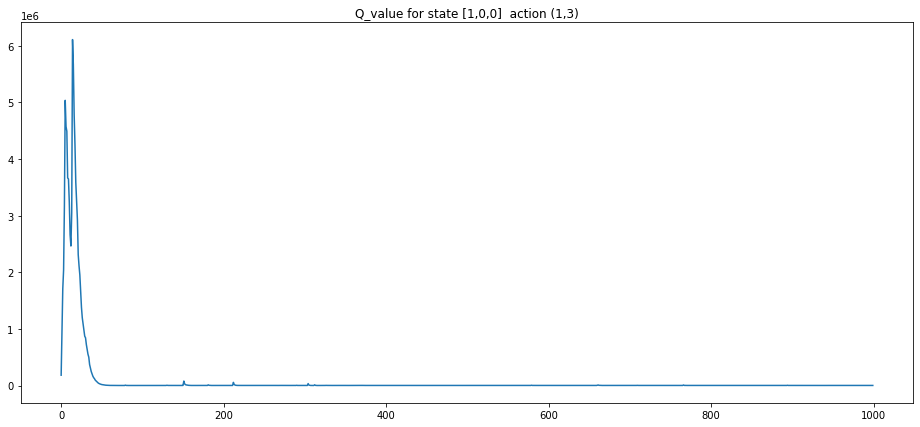

In [149]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,0,0]  action (1,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.plot(xaxis,np.asarray(agent.states_tracked))
plt.show()

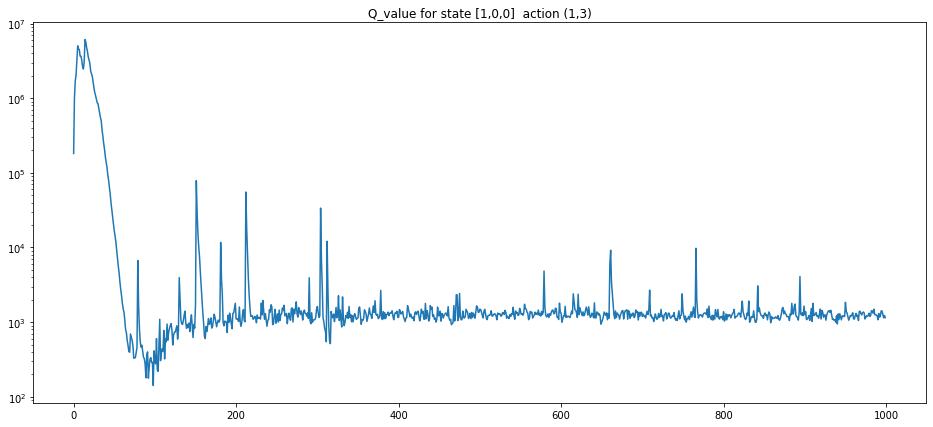

In [150]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,0,0]  action (1,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.plot(xaxis,np.asarray(agent.states_tracked))
ax = plt.axes()
ax.set_yscale('log')
plt.show()

plt.savefig('saved_plots/tracked_state.png')

<font color='green'>
    <b>Q-VALUE TRACKED FOR STATE (1,0,0) WITH ACTION (1,3)</b> <br>
    - Q-values tracked for every 5th episode <br>
    - Logarithm scale used as the initial values are very high <br>
    - As seen in the graph, the q-values converge as the number of episodes increases<br> 
</font>

#### Plot Episode vs Reward

In [79]:
with open('saved_pickle_files/summary_per_episode.pkl', 'rb') as f:
    summary_data = pickle.load(f)

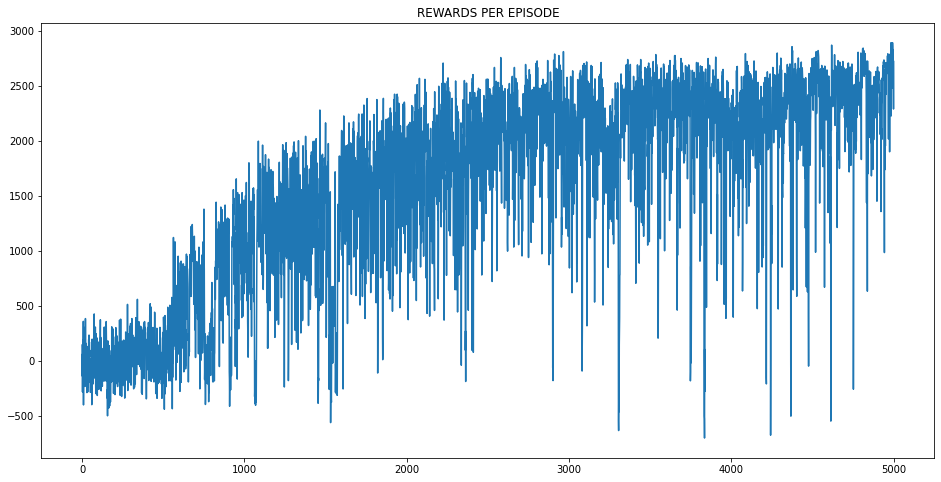

In [82]:
rewards_sample = [summary_data['REWARD'][i] for i in range(len(summary_data['REWARD'])) if (i % 1 == 0)]
plt.figure(0, figsize=(16,8))
plt.title('REWARDS PER EPISODE')
xaxis = np.asarray(range(0, len(rewards_sample)))
plt.plot(xaxis,np.asarray(rewards_sample))
plt.show()

plt.savefig('saved_plots/rewards.png')

<font color='green'>
    <b>REWARDS PER EPISODE</b> <br>
    - The plot shows the rewards obtained per episode <br>
    - Initially the rewards are low. Here the model explores more and exploits less.<br>
    - There are random instances where the rewards is very low. This could be due to any unseen scenarios explored by the model <br>
    - As the model is trained, the rewards increases and then converges between 2000 to 2500 <br>
</font>

#### Average rewards over episodes

In [118]:
# Utility method to compute the average rewards for a given range
def get_average_rewards_summary(range_value):
    average_df = pd.DataFrame(columns=['EPISODE_RANGE','AVERAGE_REWARD'])
    length = int(len(summary_data.index+1)/range_value)
    for i in range(length):
        start_index = i*range_value
        end_index = (i+1)*range_value
        average_df=average_df.append({'EPISODE_RANGE' : f'{start_index}-{end_index}',
                           'AVERAGE_REWARD' : summary_data['REWARD'][start_index:end_index].mean()
                          }, ignore_index=True) 
        
    return average_df

AVERAGE REWARD SUMMARY


,EPISODE_RANGE,AVERAGE_REWARD
0,0-500,29.178
1,500-1000,549.238
2,1000-1500,1158.718
3,1500-2000,1422.130
4,2000-2500,1778.494
5,2500-3000,2096.964
6,3000-3500,2050.630
7,3500-4000,2164.880
8,4000-4500,2165.922
9,4500-5000,2391.276


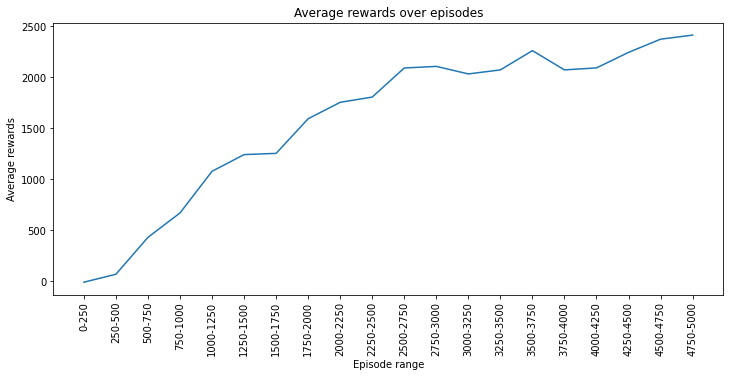

FileNotFoundError: [Errno 2] No such file or directory: 'saved_plots/average_rewards.png'

<Figure size 432x288 with 0 Axes>

In [141]:
print(f"AVERAGE REWARD SUMMARY")

average_df = get_average_rewards_summary(range_value=500)
display(average_df)

average_detailed_df = get_average_rewards_summary(range_value=250)
plt.figure(0, figsize=(12,5))
ax = plt.axes()
plt.plot(average_detailed_df['EPISODE_RANGE'],average_detailed_df['AVERAGE_REWARD'])
ax.set_xticklabels(average_detailed_df['EPISODE_RANGE'], rotation=90)
plt.title("Average rewards over episodes")
plt.xlabel("Episode range")
plt.ylabel("Average rewards")
plt.show()

plt.savefig('saved_plots/average_rewards.png')

<font color='green'>
    <b>AVERAGE REWARDS SUMMARY</b> <br>
    - The table & plot shows the change in the average rewards against the no. of episodes <br>
    - Initially the average rewards is low.<br>
    - As the model is trained with more episodes, the average rewards progressively increases and starts to converge. <br> 
    - Due to the time & resource constraints, further episodes could not be run. If trained further it could have been confirmed that the model converges around an average reward of 2.2k.<br>   
</font>

#### Plot exploration vs exploitation

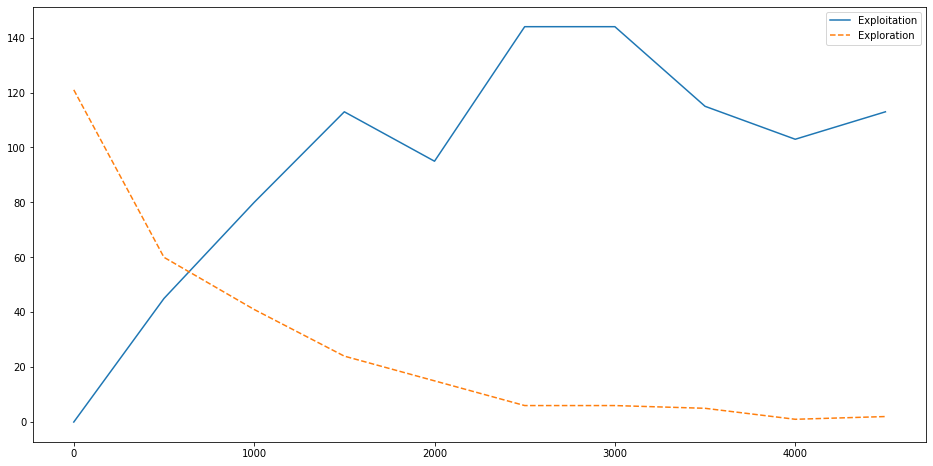

In [76]:
plt.figure(0, figsize=(16,8))
# plot lines
plt.plot(summary_data[['EPISODE']].iloc[::500, :], summary_data[['EXPLOIT_CNT']].iloc[::500, :], label = "Exploitation", linestyle="-")
plt.plot(summary_data[['EPISODE']].iloc[::500, :], summary_data[['EXPLORE_CNT']].iloc[::500, :], label = "Exploration", linestyle="--") 
plt.legend()
plt.show()


plt.savefig('saved_plots/explore_exploit.png')

<font color='green'>
    <b>EXPLORATION vs EXPLOITATION</b> <br>
    - The plot shows the no. of explorations vs no. of exploitations in each episode <br>
    - Initially the model explores more to cover new scenarios and exploits less. <br>  
    - As the number of episodes increases, the epsilon value decreases and the models starts exploiting the available data more and explores less. 
</font>

### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
import matplotlib.pyplot as plt

max_epsilon = 1.0
min_epsilon = 0.0000001
episode_count = 25000
exp_value = 1/10**(len(str(episode_count))-1)
print(f'exp:{exp_value}')
time = np.arange(0,episode_count)
epsilon = []
for i in range(0,episode_count):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-exp_value*i))
    

plt.plot(time, epsilon)
plt.show()

In [ ]:
# From starter code
total_episodes = 10000
time = np.arange(0,total_episodes)
epsilon = []
for i in range(0,total_episodes):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))
    
plt.plot(time, epsilon)
plt.show()